In [1]:
#Libraries
import os
import pandas as pd
import librosa
import numpy as np
import keras
import tensorflow
import sklearn
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
#Listing files
filelist = os.listdir("Source")

#Read files into pandas
source = pd.DataFrame(filelist)

#Rename file name column
source = source.rename(columns={0:'file'})

#Display files
source

,file
0,03-01-06-01-02-02-02.wav
1,03-01-05-01-02-01-16.wav
2,03-01-08-01-01-01-14.wav
3,03-01-06-01-02-02-16.wav
4,03-01-05-01-02-01-02.wav
...,...
1436,03-01-08-02-02-01-19.wav
1437,03-01-02-02-01-01-23.wav
1438,03-01-02-01-02-01-23.wav
1439,03-01-08-01-01-01-19.wav


In [3]:
#Extract speaker id from files
speaker_id = []
speaker_emotion = []

for i in range (0, len(source)):
    id = source["file"][i][18:20]
    emotion = source["file"][i][6:8]
    if id[0:1] == "0":
        speaker_id.append(id[1])
    else:
        speaker_id.append(id)
    
    if emotion[0:1] == "0":
        if emotion[1] == "2":
            speaker_emotion.append("1")
        else:
            speaker_emotion.append(emotion[1])
    else:
        speaker_emotion.append(emotion)
    
#Add speaker id to dataframe
source["id"] = speaker_id
source["emotion"] = speaker_emotion

source

,file,id,emotion
0,03-01-06-01-02-02-02.wav,2,6
1,03-01-05-01-02-01-16.wav,16,5
2,03-01-08-01-01-01-14.wav,14,8
3,03-01-06-01-02-02-16.wav,16,6
4,03-01-05-01-02-01-02.wav,2,5
...,...,...,...
1436,03-01-08-02-02-01-19.wav,19,8
1437,03-01-02-02-01-01-23.wav,23,1
1438,03-01-02-01-02-01-23.wav,23,1
1439,03-01-08-01-01-01-19.wav,19,8


In [4]:
#Create training & valuation dataframes
train = pd.DataFrame()
val = pd.DataFrame()

for i in range (1, 25):
    tmp = source[(source.id==str(i)) & (source.emotion=="1")]
    train_tmp = tmp.sample(6)
    val = val.append(tmp.drop(train_tmp.index))
    train = train.append(train_tmp)

train = train.reset_index()
val = val.reset_index()
train.head()

,index,file,id,emotion
0,734,03-01-01-01-02-01-01.wav,1,1
1,1279,03-01-02-01-01-01-01.wav,1,1
2,284,03-01-02-01-02-01-01.wav,1,1
3,459,03-01-01-01-01-01-01.wav,1,1
4,1292,03-01-02-02-02-01-01.wav,1,1


In [5]:
val.head()

,index,file,id,emotion
0,267,03-01-02-02-01-01-01.wav,1,1
1,281,03-01-01-01-02-02-01.wav,1,1
2,443,03-01-02-02-02-02-01.wav,1,1
3,456,03-01-02-01-01-02-01.wav,1,1
4,731,03-01-02-01-02-02-01.wav,1,1


In [6]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath("Source")+'/'+str(files.file))# Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')# Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40, n_fft=1024).T,axis=0)# Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))# Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)# Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)# Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)# Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    
    return mfccs, chroma, mel, contrast, tonnetz

In [7]:
#Extract training features
train_features = train.apply(extract_features, axis=1)
train_features

0      ([-769.673, 62.58079, -1.0462209, 17.770636, 3...
1      ([-808.4202, 68.29234, 1.4535463, 19.568098, 5...
2      ([-775.23413, 72.41384, -0.5980145, 19.375702,...
3      ([-774.7138, 59.91541, -0.76224357, 16.488583,...
4      ([-782.76666, 77.22611, 2.031555, 18.780632, 1...
                             ...                        
139    ([-827.5467, 52.37657, -3.8934863, 8.701456, -...
140    ([-769.99646, 53.1554, -6.243671, 11.750583, -...
141    ([-767.92584, 48.29075, -13.831509, 6.7319765,...
142    ([-758.3625, 46.20585, -6.9559827, 7.952592, -...
143    ([-758.182, 50.937466, -12.784158, 5.7937183, ...
Length: 144, dtype: object

In [8]:
#Extract valuation features
val_features = val.apply(extract_features, axis=1)
val_features

/Users/jthiepler/opt/anaconda3/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1012
  n_fft, y.shape[-1]


0      ([-814.5763, 77.91762, 2.2274194, 20.15795, 6....
1      ([-761.0301, 60.136326, 1.5107734, 17.480341, ...
2      ([-771.25616, 73.40374, -5.5750394, 21.456116,...
3      ([-784.1444, 72.11985, 0.9823096, 16.002165, 7...
4      ([-776.2763, 75.50344, -0.3616464, 19.120108, ...
                             ...                        
139    ([-818.9859, 47.50039, -5.626721, 8.807278, -6...
140    ([-760.54016, 50.296085, -8.603899, 8.390881, ...
141    ([-773.26056, 48.77085, -0.1524375, 6.8572464,...
142    ([-760.6401, 49.09821, -8.325517, 4.9338107, -...
143    ([-763.53705, 49.9937, -6.579894, 7.873664, -8...
Length: 144, dtype: object

In [9]:
#Extract test features
#test_features = val.apply(extract_features, axis=1)
#test_features

In [10]:
features_train = []
for i in range(0, len(train_features)):
    features_train.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))

In [11]:
features_val = []
for i in range(0, len(val_features)):
    features_val.append(np.concatenate((
        val_features[i][0],
        val_features[i][1], 
        val_features[i][2], 
        val_features[i][3],
        val_features[i][4]), axis=0))

In [12]:
X_train = np.array(features_train)
X_val = np.array(features_train)

In [13]:
y_train = np.array(train["id"])
print(y_train)
y_val = np.array(val["id"])

['1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '2' '3' '3' '3' '3' '3' '3'
 '4' '4' '4' '4' '4' '4' '5' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '6'
 '7' '7' '7' '7' '7' '7' '8' '8' '8' '8' '8' '8' '9' '9' '9' '9' '9' '9'
 '10' '10' '10' '10' '10' '10' '11' '11' '11' '11' '11' '11' '12' '12'
 '12' '12' '12' '12' '13' '13' '13' '13' '13' '13' '14' '14' '14' '14'
 '14' '14' '15' '15' '15' '15' '15' '15' '16' '16' '16' '16' '16' '16'
 '17' '17' '17' '17' '17' '17' '18' '18' '18' '18' '18' '18' '19' '19'
 '19' '19' '19' '19' '20' '20' '20' '20' '20' '20' '21' '21' '21' '21'
 '21' '21' '22' '22' '22' '22' '22' '22' '23' '23' '23' '23' '23' '23'
 '24' '24' '24' '24' '24' '24']


In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical# Hot encoding y
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))

In [15]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
#X_test = ss.transform(X_test)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 30 classes
model = Sequential()
model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(24, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [25]:
X_val.shape

(144, 193)

In [26]:
history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Train on 144 samples, validate on 144 samples
Epoch 1/100
144/144 [==============================] - 1s 8ms/step - loss: 3.3972 - accuracy: 0.0208 - val_loss: 3.0683 - val_accuracy: 0.0694
Epoch 2/100
144/144 [==============================] - 0s 110us/step - loss: 3.2865 - accuracy: 0.0625 - val_loss: 2.9530 - val_accuracy: 0.1181
Epoch 3/100
144/144 [==============================] - 0s 114us/step - loss: 3.1581 - accuracy: 0.0764 - val_loss: 2.8548 - val_accuracy: 0.1736
Epoch 4/100
144/144 [==============================] - 0s 112us/step - loss: 3.0492 - accuracy: 0.0694 - val_loss: 2.7696 - val_accuracy: 0.2847
Epoch 5/100
144/144 [==============================] - 0s 113us/step - loss: 2.9221 - accuracy: 0.1528 - val_loss: 2.6921 - val_accuracy: 0.3819
Epoch 6/100
144/144 [==============================] - 0s 104us/step - loss: 2.8421 - accuracy: 0.1667 - val_loss: 2.6198 - val_accuracy: 0.4792
Epoch 7/100
144/144 [==============================] - 0s 108us/step - loss: 2.8988 - 

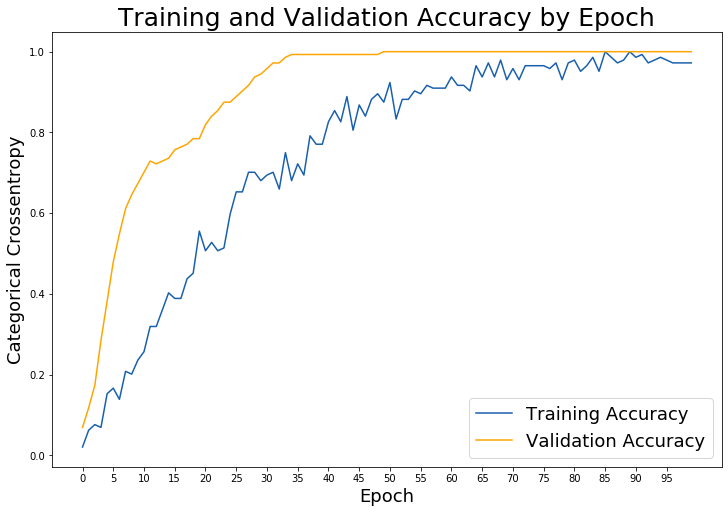

In [27]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']# Set figure size.
plt.figure(figsize=(12, 8))# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);